# Homework 08 LSTM Stock Predictions

# Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv (https://sjsu.instructure.com/courses/1585768/files/75906517/download?download_frd=1) ).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Google_Stock_Price_Train.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,533.709833,151.904442,279.12,404.115,537.47,654.9225,816.68
High,1258.0,537.880223,153.008811,281.21,406.765,540.75,662.5875,816.68
Low,1258.0,529.007409,150.552807,277.22,401.765,532.99,644.8000,805.14


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


# Step 2. Preprocess the data as you see fit


In [5]:
df['Volume'] = df['Volume'].str.replace(',', '').astype(int)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1258,2014-07-03 20:00:45.786963456,2012-01-03 00:00:00,2013-04-05 18:00:00,2014-07-05 00:00:00,2015-10-01 18:00:00,2016-12-30 00:00:00,NaN
Open,1258.0,533.709833,279.12,404.115,537.47,654.9225,816.68,151.904442
High,1258.0,537.880223,281.21,406.765,540.75,662.5875,816.68,153.008811
Low,1258.0,529.007409,277.22,401.765,532.99,644.8,805.14,150.552807
Close,1258.0,712.669666,491.2,576.74,695.675,782.105,1216.83,164.752591
Volume,1258.0,3158106.756757,7900.0,1621700.0,2566150.0,4122500.0,24977900.0,2273725.584816


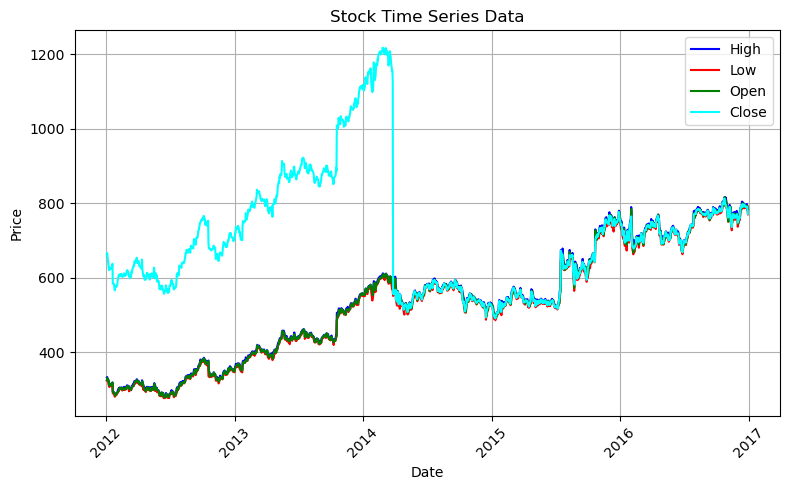

In [7]:
import matplotlib.pyplot as plt

def plot_stocks(df):
    plt.figure(figsize=(8, 5))

    # Plotting High and Low prices
    plt.plot(df['Date'], df['High'], label='High', color='blue')
    plt.plot(df['Date'], df['Low'], label='Low', color='red')
    plt.plot(df['Date'], df['Open'], label='Open', color='green')
    plt.plot(df['Date'], df['Close'], label='Close', color='cyan')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Time Series Data')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
plot_stocks(df)

In [8]:
def filter_bad_closing_records(df):
    given_date = '3/27/2014'
    given_date = pd.to_datetime(given_date)
    print("filter based on he date = ", given_date)
    df = df[df['Date']>= given_date]
    return df
    

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

def scale_features(data):
    print("Scaling the data ")
    print(f" \t sample input = {data[:5] = }")
    scaled_data = scaler.fit_transform(np.array(data)[... , None]).squeeze()
    print(f" \t Shape of the {scaled_data.shape=} \n")
    return scaled_data

# Step 3. Split into 80% train 20% prediction


In [10]:
import math
import numpy as np

import torch
import torch.nn as nn

def create_dataset(data, look_back):
    X = []
    y = []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])

    return np.array(X)[... , None], np.array(y)[... , None]



def train_test_split(X, test_size=.2, look_back=7):
    X, y = create_dataset(X, look_back)
    # print(f"converting lookbacks shape : {X.shape = }, {y.shape = } ")    
    X_train = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
    y_train = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
    X_test = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
    y_test = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()
    
    print(f"Training Data Size = {X_train.shape = }, {y_train.shape = }")
    print(f"Test Data Size     = {X_test.shape = }, {y_test.shape = }")
    
    return X_train, X_test, y_train, y_test
  
    

column = "Open"
print(f"Size of the data {len(df)}")
X = df[column].values
print(f"length of the values = {len(X) = }")
scaled_data = scale_features(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_data, test_size=0.2, look_back=5)
print(f"\n sample Data {X_train[:1] = }")

Size of the data 1258
length of the values = len(X) = 1258
Scaling the data 
 	 sample input = data[:5] = array([325.25, 331.27, 329.83, 328.34, 322.04])
 	 Shape of the scaled_data.shape=(1258,) 

Training Data Size = X_train.shape = torch.Size([1002, 5, 1]), y_train.shape = torch.Size([1002, 1])
Test Data Size     = X_test.shape = torch.Size([251, 5, 1]), y_test.shape = torch.Size([251, 1])

 sample Data X_train[:1] = tensor([[[0.0858],
         [0.0970],
         [0.0943],
         [0.0916],
         [0.0798]]])


# Step 4. Train the model on the data


In [11]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through LSTM layer
        out, (hidden, ceil) = self.lstm(x)
        out = self.fc(hidden[-1 , :])
        return out

    
model = LSTMModel(input_size=1, hidden_size=64)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [21]:
from sklearn.metrics import mean_squared_error

def get_rmse(model, X, y, look_back, dataType):
    model.eval()
    with torch.no_grad():
        output = model(X)
    
    y_pred = scaler.inverse_transform(output.numpy())
    y_real = scaler.inverse_transform(y.numpy())
    
    # Calculate RMSE for the given data
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    print(f"{dataType} RMSE for look_back = {look_back}, RMSE = {rmse}")

    return rmse


def train(model, X_train, y_train, num_epochs=20):
    # Train the model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % (num_epochs//5) == 0:
            print(f'\tEpoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model



def plot_results(model, X_test, y_test, look_back):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
    
    y_pred = scaler.inverse_transform(output.numpy())
    y_real = scaler.inverse_transform(y_test.numpy())
    
    plt.figure(figsize=(8, 4))
    plt.title(f"Real Price and Predicted Price for the look_back period = {look_back}")
    plt.plot(y_pred.squeeze(), label = "predicted")
    plt.plot(y_real.squeeze(), label = "real")
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()
    

length of the values = len(X) = 1258
Scaling the data 
 	 sample input = data[:5] = array([325.25, 331.27, 329.83, 328.34, 322.04])
 	 Shape of the scaled_data.shape=(1258,) 

Training Data Size = X_train.shape = torch.Size([1002, 5, 1]), y_train.shape = torch.Size([1002, 1])
Test Data Size     = X_test.shape = torch.Size([251, 5, 1]), y_test.shape = torch.Size([251, 1])
	Epoch [40/200], Loss: 0.0303
	Epoch [80/200], Loss: 0.0130
	Epoch [120/200], Loss: 0.0011
	Epoch [160/200], Loss: 0.0010
	Epoch [200/200], Loss: 0.0008
Train RMSE for look_back = 5, RMSE = 15.396257400512695
Test RMSE for look_back = 5, RMSE = 33.442543029785156


 Best Performance So far for the Lookback period = 5


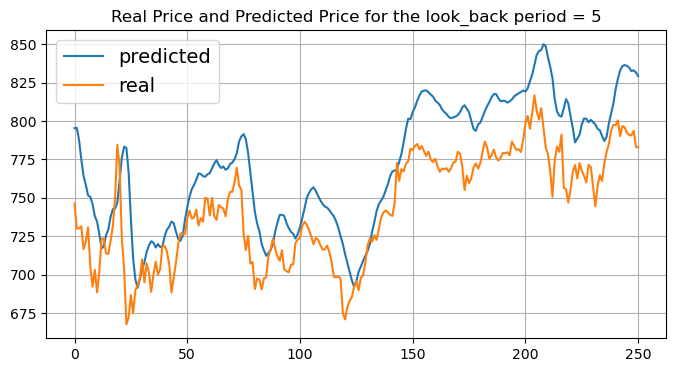

Training Data Size = X_train.shape = torch.Size([1001, 6, 1]), y_train.shape = torch.Size([1001, 1])
Test Data Size     = X_test.shape = torch.Size([251, 6, 1]), y_test.shape = torch.Size([251, 1])
	Epoch [40/200], Loss: 0.0251
	Epoch [80/200], Loss: 0.0042
	Epoch [120/200], Loss: 0.0011
	Epoch [160/200], Loss: 0.0009
	Epoch [200/200], Loss: 0.0007
Train RMSE for look_back = 6, RMSE = 14.008583068847656
Test RMSE for look_back = 6, RMSE = 24.894500732421875


 Best Performance So far for the Lookback period = 6


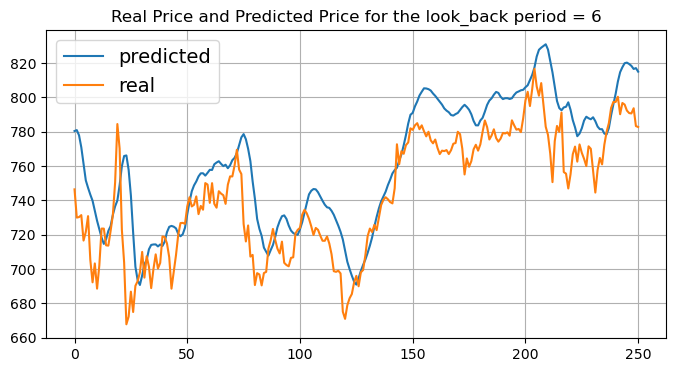

Training Data Size = X_train.shape = torch.Size([1000, 7, 1]), y_train.shape = torch.Size([1000, 1])
Test Data Size     = X_test.shape = torch.Size([251, 7, 1]), y_test.shape = torch.Size([251, 1])
	Epoch [40/200], Loss: 0.0311
	Epoch [80/200], Loss: 0.0023
	Epoch [120/200], Loss: 0.0013
	Epoch [160/200], Loss: 0.0008
	Epoch [200/200], Loss: 0.0007
Train RMSE for look_back = 7, RMSE = 13.859295845031738
Test RMSE for look_back = 7, RMSE = 18.337757110595703


 Best Performance So far for the Lookback period = 7


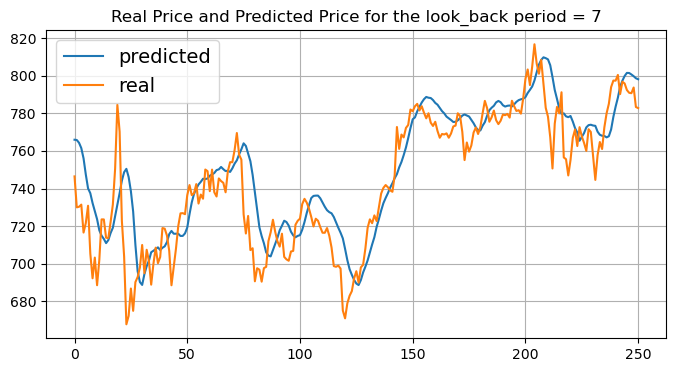

Training Data Size = X_train.shape = torch.Size([1000, 8, 1]), y_train.shape = torch.Size([1000, 1])
Test Data Size     = X_test.shape = torch.Size([250, 8, 1]), y_test.shape = torch.Size([250, 1])
	Epoch [40/200], Loss: 0.0207
	Epoch [80/200], Loss: 0.0015
	Epoch [120/200], Loss: 0.0007
	Epoch [160/200], Loss: 0.0006
	Epoch [200/200], Loss: 0.0006
Train RMSE for look_back = 8, RMSE = 13.267036437988281
Test RMSE for look_back = 8, RMSE = 16.61707305908203


 Best Performance So far for the Lookback period = 8


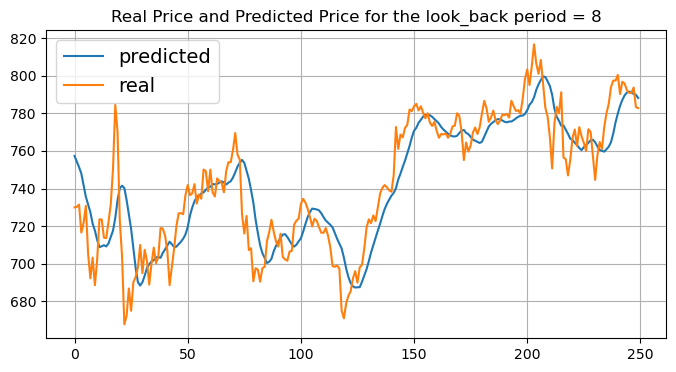

Training Data Size = X_train.shape = torch.Size([999, 9, 1]), y_train.shape = torch.Size([999, 1])
Test Data Size     = X_test.shape = torch.Size([250, 9, 1]), y_test.shape = torch.Size([250, 1])
	Epoch [40/200], Loss: 0.0254
	Epoch [80/200], Loss: 0.0021
	Epoch [120/200], Loss: 0.0014
	Epoch [160/200], Loss: 0.0009
	Epoch [200/200], Loss: 0.0007
Train RMSE for look_back = 9, RMSE = 14.653979301452637
Test RMSE for look_back = 9, RMSE = 20.437705993652344
Training Data Size = X_train.shape = torch.Size([998, 10, 1]), y_train.shape = torch.Size([998, 1])
Test Data Size     = X_test.shape = torch.Size([250, 10, 1]), y_test.shape = torch.Size([250, 1])
	Epoch [40/200], Loss: 0.0269
	Epoch [80/200], Loss: 0.0025
	Epoch [120/200], Loss: 0.0013
	Epoch [160/200], Loss: 0.0009
	Epoch [200/200], Loss: 0.0007
Train RMSE for look_back = 10, RMSE = 14.36329174041748
Test RMSE for look_back = 10, RMSE = 18.271093368530273
Training Data Size = X_train.shape = torch.Size([997, 11, 1]), y_train.shape 

In [30]:
rmse_dict = {}
look_back_periods = [i for i in range(5, 21)]

column = "Open"

X = df[column].values
print(f"length of the values = {len(X) = }")
scaled_data = scale_features(X)

best_model, min_rmse, min_look_back_period = None, float('inf'), -1

for look_back in look_back_periods:
    X_train, X_test, y_train, y_test = train_test_split(scaled_data, test_size=0.2, look_back=look_back)
    model = LSTMModel(input_size=1, hidden_size=64)
    model = train(model, X_train, y_train, num_epochs=200)    

    train_rmse = get_rmse(model, X_train, y_train, look_back, "Train")
    test_rmse  = get_rmse(model, X_test, y_test, look_back, "Test")
    
    rmse_dict[look_back] = (model, train_rmse, test_rmse)
    
    if test_rmse < min_rmse:
        print(f"\n\n Best Performance So far for the Lookback period = {look_back}")
        plot_results(model, X_test, y_test, look_back)
        best_model = model
        min_rmse = test_rmse
        min_look_back_period = look_back
    

# Step 5. Report on the results of your model

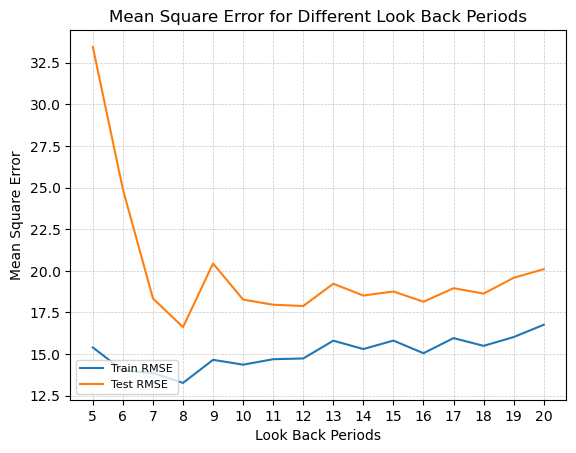

In [31]:
plt.plot([rmse_dict[i][1] for i in look_back_periods], label = "Train RMSE" )
plt.plot([rmse_dict[i][2] for i in look_back_periods], label = "Test RMSE" )
plt.legend(loc='lower left', fontsize=8)
plt.xlabel('Look Back Periods')
plt.ylabel('Mean Square Error')
plt.title('Mean Square Error for Different Look Back Periods')
xticks_values = np.arange(look_back_periods[0], look_back_periods[-1]+1, 1)
plt.xticks([i for i in range(len(look_back_periods))], look_back_periods) 
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

Training Data Size = X_train.shape = torch.Size([1000, 8, 1]), y_train.shape = torch.Size([1000, 1])
Test Data Size     = X_test.shape = torch.Size([250, 8, 1]), y_test.shape = torch.Size([250, 1])
1258 1008 250 250


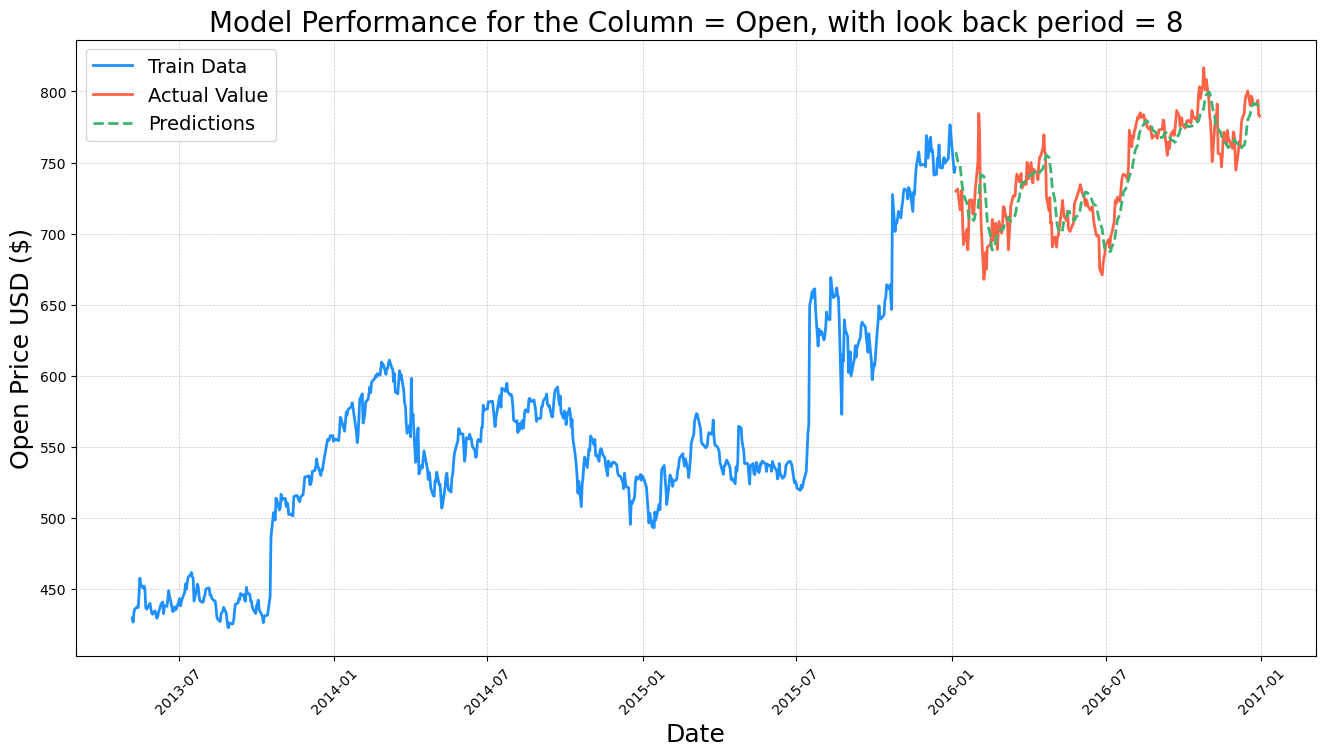

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_result(df, N, predictions, look_back):
    
    N_train, N_test = N - len(predictions), len(predictions)
    train = df.iloc[int(N_train/3):N_train].copy()
    print(N, N_train, N_test, len(predictions))

    valid = df.iloc[N_train:].copy()
    valid['Predictions'] = predictions

    # Plotting
    plt.figure(figsize=(16,8))
    plt.title(f'Model Performance for the Column = {column}, with look back period = {look_back}', fontsize=20)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'{column} Price USD ($)', fontsize=18)

    # Actual prices for the training part
    plt.plot(train['Date'], train[column], label='Train Data', color='dodgerblue', linewidth=2)
    # plt.plot(train['Date'], train['Open'], label='Train Data', color='green', linewidth=2)

    # Actual prices for the test part
    plt.plot(valid['Date'], valid[column], label='Actual Value', color='tomato', linewidth=2)

    # Predicted prices
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='mediumseagreen', linestyle='--', linewidth=2)

    plt.legend(loc='upper left', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    

X_train, X_test, y_train, y_test = train_test_split(scaled_data, test_size=0.2, look_back=min_look_back_period)

best_model.eval()
with torch.no_grad():
    output = best_model(X_test)

y_pred = scaler.inverse_transform(output.numpy())
plot_result(df, len(scaled_data), y_pred, min_look_back_period)
